In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import lightgbm as lgb
%matplotlib inline
from sklearn.metrics import mean_absolute_error
from chinese_calendar import is_workday, is_holiday
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

/home/zhouzr/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Data

In [2]:
cooling = pd.read_csv('./data/cooling_hour.csv', parse_dates=['时间'])

In [3]:
cooling.head()

,时间,ce_cold,ce_temp,cw_cold,cw_temp,dry_temp,o1_cold,o1_temp,o2_cold,o2_temp
0,2017-05-25 12:00:00,1698.555217,24.509726,382.464298,25.470814,26.374286,1032.862150,23.879254,694.506345,23.409014
1,2017-05-25 13:00:00,1933.293879,24.566837,353.073287,25.482020,26.926333,1103.429427,23.988247,717.551680,23.440700
2,2017-05-25 14:00:00,1694.346086,24.407470,395.100368,25.321645,27.579667,1091.022464,24.159955,720.426745,23.482717
3,2017-05-25 15:00:00,1583.777496,24.462997,399.857500,25.279103,27.553167,1105.372427,24.279813,707.009301,23.488158
4,2017-05-25 16:00:00,1657.522083,24.486100,411.738206,25.382945,27.667000,1203.675505,24.444663,724.174842,23.463333


## Feature

In [4]:
def add_feature(x):
    x['is_holiday'] = x['时间'].apply(is_holiday).astype(int)
    x['month'] = x['时间'].dt.month
    x['hour'] = x['时间'].dt.hour
    x['weekday'] = x['时间'].dt.weekday
    return x

cooling = add_feature(cooling)

In [5]:
cooling.loc[:, 'ce_cold_h24'] = cooling['ce_cold'].shift(24)
cooling.loc[:, 'cw_cold_h24'] = cooling['cw_cold'].shift(24)
cooling.loc[:, 'o1_cold_h24'] = cooling['o1_cold'].shift(24)
cooling.loc[:, 'o2_cold_h24'] = cooling['o2_cold'].shift(24)

cooling.loc[:, 'ce_temp_h24'] = cooling['ce_temp'].shift(24)
cooling.loc[:, 'cw_temp_h24'] = cooling['cw_temp'].shift(24)
cooling.loc[:, 'o1_temp_h24'] = cooling['o1_temp'].shift(24)
cooling.loc[:, 'o2_temp_h24'] = cooling['o2_temp'].shift(24)

In [6]:
cooling.head()

,时间,ce_cold,ce_temp,cw_cold,cw_temp,dry_temp,o1_cold,o1_temp,o2_cold,o2_temp,...,hour,weekday,ce_cold_h24,cw_cold_h24,o1_cold_h24,o2_cold_h24,ce_temp_h24,cw_temp_h24,o1_temp_h24,o2_temp_h24
0,2017-05-25 12:00:00,1698.555217,24.509726,382.464298,25.470814,26.374286,1032.862150,23.879254,694.506345,23.409014,...,12,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-05-25 13:00:00,1933.293879,24.566837,353.073287,25.482020,26.926333,1103.429427,23.988247,717.551680,23.440700,...,13,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2017-05-25 14:00:00,1694.346086,24.407470,395.100368,25.321645,27.579667,1091.022464,24.159955,720.426745,23.482717,...,14,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2017-05-25 15:00:00,1583.777496,24.462997,399.857500,25.279103,27.553167,1105.372427,24.279813,707.009301,23.488158,...,15,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2017-05-25 16:00:00,1657.522083,24.486100,411.738206,25.382945,27.667000,1203.675505,24.444663,724.174842,23.463333,...,16,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Model

In [7]:
def build_model(features, target, df, param, train_size=0.9, valid_size=0.05, test_size=0.05):
    size = df.shape[0]
    t1 = int(size * train_size)
    t2 = t1 + int(size * valid_size)
    
    train = lgb.Dataset(df.iloc[:t1][features], df.iloc[:t1][target].values)
    valid = lgb.Dataset(df.iloc[t1:t2][features], df.iloc[t1:t2][target].values)
    
    model = lgb.train(param, train, valid_sets=[train, valid], num_boost_round=10000, 
          early_stopping_rounds=30, verbose_eval=200)
    test_preds = model.predict(df.iloc[t2:][features])
    test_score = np.mean(np.abs(test_preds - df.iloc[t2:][target]))

    test_trues = df.iloc[t2:][target]

    preds = pd.Series(test_preds, index = df['时间'][t2:].values)
    trues = pd.Series(test_trues.values, index = df['时间'][t2:].values)
    
    t = trues.resample('D').sum().iloc[:-1].dropna()
    p = preds.resample('D').sum().iloc[:-1].dropna()
    score1 = ((p - t)).abs().mean()
    
    print(f'test set mae: {test_score:.2f}, day mae: {score1:.2f}')
    return model, t, p

In [8]:
param = {'objective': 'regression', 
         'learning_rate': 0.01, 
         'num_leaves': 31,
         'max_depth': -1,
         'metric': 'l1',
         'seed': 42,
        }

## office 1 cooling forecast

In [9]:
model_o1, o1_true, o1_pred = build_model(
    features=[
        'o1_temp', 'o1_cold_h24', #'o1_temp_h24',
#         'o2_temp', 'o2_cold_h24', 'o2_temp_h24',
#         'cw_temp', 'cw_cold_h24', 'cw_temp_h24',
#         'ce_temp', 'ce_cold_h24', 'ce_temp_h24',
        'weekday', 'is_holiday', 'month', 'hour', 'dry_temp'], 
    target='o1_cold',
    df=cooling,
    param=param,
)

Training until validation scores don't improve for 30 rounds.
[200]	training's l1: 127.113	valid_1's l1: 99.4863
[400]	training's l1: 76.2985	valid_1's l1: 60.8771
[600]	training's l1: 66.1791	valid_1's l1: 53.0401
Early stopping, best iteration is:
[616]	training's l1: 65.9084	valid_1's l1: 53.0006
test set mae: 96.41, day mae: 1263.38


Text(0.5,1,'office 1 cooling')

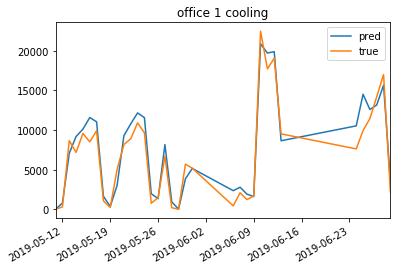

In [10]:
o1_pred.plot(label='pred')
o1_true.plot(label='true')
plt.legend()
plt.title('office 1 cooling')

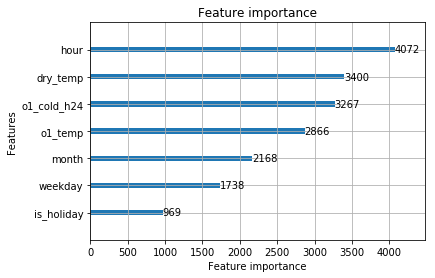

In [11]:
lgb.plot_importance(model_o1)

## office 2

In [12]:
model_o2, o2_true, o2_pred = build_model(
    features=[
#         'o1_temp', 'o1_cold_h24', 'o1_temp_h24',
        'o2_temp', 'o2_cold_h24', #'o2_temp_h24',
#         'cw_temp', 'cw_cold_h24', 'cw_temp_h24',
#         'ce_temp', 'ce_cold_h24', 'ce_temp_h24',
        'weekday', 'is_holiday', 'month', 'hour', 'dry_temp'], 
    target='o2_cold',
    df=cooling,
    param=param,
)

Training until validation scores don't improve for 30 rounds.
[200]	training's l1: 87.6421	valid_1's l1: 72.0436
[400]	training's l1: 47.0871	valid_1's l1: 39.2315
[600]	training's l1: 40.4106	valid_1's l1: 34.2946
Early stopping, best iteration is:
[651]	training's l1: 39.8808	valid_1's l1: 34.1541
test set mae: 62.08, day mae: 753.92


Text(0.5,1,'office 2 cooling')

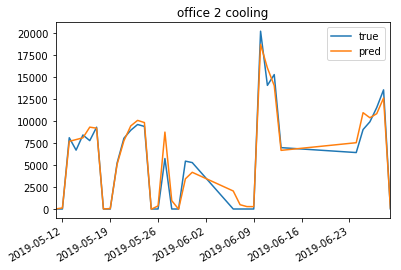

In [13]:
o2_true.plot(label='true')
o2_pred.plot(label='pred')
plt.legend()
plt.title('office 2 cooling')

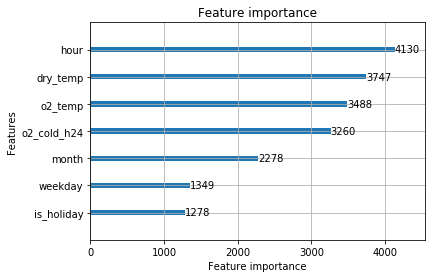

In [14]:
lgb.plot_importance(model_o2)

## commercial east cooling

In [15]:
model_ce, ce_trues, ce_preds = build_model(
    features=[
#         'o1_temp', 'o1_cold_h24', 'o1_temp_h24',
#         'o2_temp', 'o2_cold_h24', 'o2_temp_h24',
#         'cw_temp', 'cw_cold_h24', 'cw_temp_h24',
        'ce_temp', 'ce_cold_h24', #'ce_temp_h24',
        'weekday', 'is_holiday', 'month', 'hour', 'dry_temp'],  
    target='ce_cold',
    df=cooling,
    param=param,
)

Training until validation scores don't improve for 30 rounds.
[200]	training's l1: 250.434	valid_1's l1: 198.612
[400]	training's l1: 171.893	valid_1's l1: 125.888
[600]	training's l1: 156.572	valid_1's l1: 114.708
Early stopping, best iteration is:
[729]	training's l1: 152.837	valid_1's l1: 111.189
test set mae: 205.87, day mae: 2973.04


Text(0.5,1,'commercial east cooling')

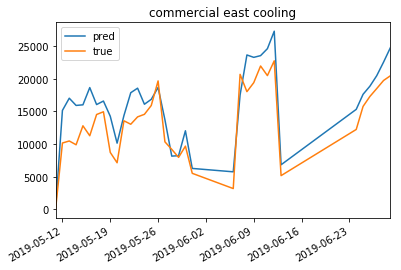

In [16]:
ce_preds.plot(label='pred')
ce_trues.plot(label='true')
plt.legend()
plt.title('commercial east cooling')

## commercial west cooling forecast

In [17]:
model_cw, cw_trues, cw_preds = build_model(
    features=[
#         'o1_temp', 'o1_cold_h24', 'o1_temp_h24',
#         'o2_temp', 'o2_cold_h24', 'o2_temp_h24',
        'cw_temp', 'cw_cold_h24', #'cw_temp_h24',
#         'ce_temp', 'ce_cold_h24', 'ce_temp_h24',
        'weekday', 'is_holiday', 'month', 'hour', 'dry_temp'], 
    target='cw_cold',
    df=cooling,
    param=param,
)

Training until validation scores don't improve for 30 rounds.
[200]	training's l1: 73.2719	valid_1's l1: 86.2381
[400]	training's l1: 53.4445	valid_1's l1: 67.242
Early stopping, best iteration is:
[489]	training's l1: 50.8382	valid_1's l1: 63.5945
test set mae: 83.14, day mae: 1098.79


Text(0.5,1,'commercial west cooling')

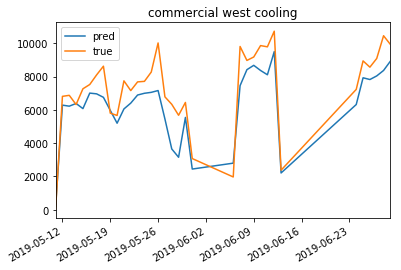

In [18]:
cw_preds.plot(label='pred')
cw_trues.plot(label='true')
plt.legend()
plt.title('commercial west cooling')

## totle cooling forecast

In [19]:
total_preds = o1_pred + o2_pred + ce_preds + cw_preds
total_trues = o1_true + o2_true + ce_trues + cw_trues

In [29]:
total_preds.tail()

2019-06-25    50978.693115
2019-06-26    49615.618355
2019-06-27    52478.480620
2019-06-28    59152.136040
2019-06-29    37333.964797
dtype: float64

In [30]:
total_trues.tail()

2019-06-25    43647.960613
2019-06-26    47178.582615
2019-06-27    53293.776090
2019-06-28    60702.113621
2019-06-29    32564.024641
dtype: float64

Text(0.5,1,'totle cooling forecast')

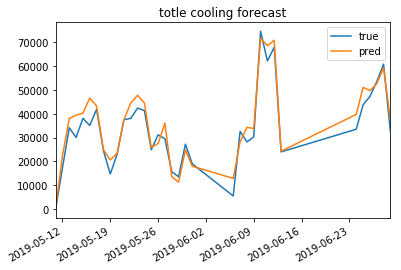

In [33]:
total_trues.plot(label='true')
total_preds.plot(label='pred')
plt.legend()
plt.title('totle cooling forecast')

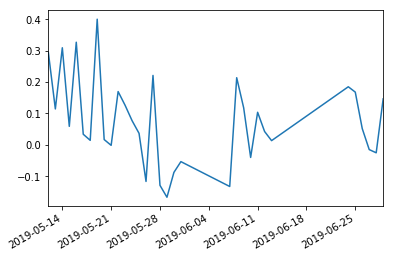

In [32]:
score = (((total_preds - total_trues) / total_trues).iloc[1:])
score = score[score < 1]
score.plot()

In [22]:
score.abs().mean()

0.12155457507938712

In [23]:
score.abs().quantile(.80)

0.17888223014006754

## Save Resulte

In [45]:
import pickle

In [55]:
pickle.dump(model_ce, open('./model/ce.pkl', 'wb'))
pickle.dump(model_cw, open('./model/cw.pkl', 'wb'))
pickle.dump(model_o1, open('./model/o1.pkl', 'wb'))
pickle.dump(model_o2, open('./model/o2.pkl', 'wb'))